This notebook trys to predict the sale price of houses in Ames, Iowa, given 70+ explanatory variables. This is another kaggle data set/competition (found here: https://www.kaggle.com/c/house-prices-advanced-regression-techniques) with the goal of building a model with the lowest root mean squared logarithmic error. A root mean squared log error of 0 is the best possible, so minimizing it the goal. To accomplish this goal, a lot of feature engineering will be done so as to give the model more data with which to work. 

In [1]:
import pandas
import math
import numpy as np

In [2]:
df_train = pandas.read_csv('train.csv')
df_test = pandas.read_csv('test.csv')

train_csv_ids = df_train['Id'].values.ravel()
test_csv_ids = df_test['Id'].values.ravel()

df = pandas.concat( [df_train, df_test], sort=True ).reset_index(drop=True)

In [3]:
print('Num rows: {}'.format(df.shape[0]))
print('Num cols: {}'.format(df.shape[1]))

Num rows: 2919
Num cols: 81


In [4]:
print('Column \t Number of Empty Entries \t First 3 Entries')
for col in df.columns:
    print('{} \t\t {} \t\t {}'.format(col, df[col].isnull().sum(), df[col].values[0:3]))

Column 	 Number of Empty Entries 	 First 3 Entries
1stFlrSF 		 0 		 [ 856 1262  920]
2ndFlrSF 		 0 		 [854   0 866]
3SsnPorch 		 0 		 [0 0 0]
Alley 		 2721 		 [nan nan nan]
BedroomAbvGr 		 0 		 [3 3 3]
BldgType 		 0 		 ['1Fam' '1Fam' '1Fam']
BsmtCond 		 82 		 ['TA' 'TA' 'TA']
BsmtExposure 		 82 		 ['No' 'Gd' 'Mn']
BsmtFinSF1 		 1 		 [706. 978. 486.]
BsmtFinSF2 		 1 		 [0. 0. 0.]
BsmtFinType1 		 79 		 ['GLQ' 'ALQ' 'GLQ']
BsmtFinType2 		 80 		 ['Unf' 'Unf' 'Unf']
BsmtFullBath 		 2 		 [1. 0. 1.]
BsmtHalfBath 		 2 		 [0. 1. 0.]
BsmtQual 		 81 		 ['Gd' 'Gd' 'Gd']
BsmtUnfSF 		 1 		 [150. 284. 434.]
CentralAir 		 0 		 ['Y' 'Y' 'Y']
Condition1 		 0 		 ['Norm' 'Feedr' 'Norm']
Condition2 		 0 		 ['Norm' 'Norm' 'Norm']
Electrical 		 1 		 ['SBrkr' 'SBrkr' 'SBrkr']
EnclosedPorch 		 0 		 [0 0 0]
ExterCond 		 0 		 ['TA' 'TA' 'TA']
ExterQual 		 0 		 ['Gd' 'TA' 'Gd']
Exterior1st 		 1 		 ['VinylSd' 'MetalSd' 'VinylSd']
Exterior2nd 		 1 		 ['VinylSd' 'MetalSd' 'VinylSd']
Fence 		 2348 		 [nan nan nan]
Fi

So the first feature engineering plan I made from this and the data dictionary was hardly more helpful than just outright dummy encoding everything (rmsle of about 0.15 on Kaggle). This second plan will hopefully improve upon the first. What I neglected to realize was that some of the missing entries actually tell a story of their own; they can be important. Additionally, I didn't do enough feature extraction from the columns, so I'll try doing more of that as well. Here's the plan:


### 1stFlrSF 
+ leave as is

### 2ndFlrSF 
+ leave as is

### 3SsnPorch 
+ leave as is

### Alley 
+ set NaNs to NA's
+ dummy encode

### BedroomAbvGr 
+ leave as is

### BldgType 
+ dummy encode

### BsmtCond 
+ when missing: 
1. total bsmt sqft is 0.0 or NaN ==> NA
2. total bsmt sqft > 0.0 and is not NaN ==> TA
+ ordinal encode

### BsmtExposure
+ when missing:
1. total bsmt sqft is 0.0 or NaN ==> NA
2. total bsmt sqft > 0.0 ==> No
+ ordinal encode

### BsmtFinSF1  and BsmtFinSF2
+ drop; not reliable: when Unf, often does not add up to BsmtUnfSF

### BsmtFinType1 and BsmtFinType2
+ set NaN to NA

### BsmtFullBath
+ set 2 NaN to 0’s

### BsmtHalfBath
+ set 2 NaN to 0’s

### BsmtQual
+ when missing:
1. total bsmt sqft is 0.0 or NaN ==> NA
2. total bsmt sqft > 0.0 ==> TA
+ ordinal encode

### BsmtUnfSF
+ set 1 NaN to 0

### CentralAir
+ binary encode

### Condition1 and Condition2
+ combined into 9 binary columns

### Electrical
+ set 1 NaN to ‘Mix’
+ dummy encode

### EnclosedPorch
+ leave as is

### ExterCond
+ ordinal encode

### ExterQual
+ ordinal encode

### Exterior1st and Exterior2nd
+ 1 NaN to ‘Other’
+ combined into 17 binary columns

### Fence
+ There are no NA’s in the data set, so it’s safe to set all NaNs to NA’s
+ dummy encode

### FireplaceQu
+ There are no NA’s in the data set, so it’s safe to set all NaNs to NA’s
+ No instance where NaN here but != Fireplaces (count col)
+ ordinal encode

### Foundation
+ dummy encode

### FullBath
+ leave as is

### Functional
+ 2 NaNs to Typ since “Assume typical unless deductions are warranted”
+ ordinal encode; Typ=0 and Sal=7

### Garage Area
+ 1 NaN impute average GarageArea
+ leave as is otherwise

### GarageCars
+ 1 NaN impute average GarageCars
+ leave as is otherwise

### GarageCond
+ No NA’s in dataset, so it’s safe to make all NaNs NA’s
+ ordinal encode

### GarageFinish
+ No NA’s in dataset, so it’s safe to make all NaNs NA’s
+ ordinal encode

### GarageQual
+ No NA’s in dataset, so it’s safe to make all NaNs NA’s
+ ordinal encode

### GarageType
+ No NA’s in dataset, so it’s safe to make all NaNs NA’s
+ dumm encode

### GarageYrBlt
+ so as to not throw off any regressor, all NaNs to average YrBlt

### GrLivArea
+ leave as is

### HalfBath
+ leave as is

### Heating
+ dummy encode

### HeatingQC
+ ordinal encode

### HouseStyle
+ convert to num floors

### Id
+ leave as is

### KitchenAbvGr
+ leave as is

### KitchenQual
+ 1 NaN to TA

### LandContour
+ dummy encode

### LandSlope
+ ordinal encode

### LotArea
+ leave as is

### LotConfig
+ dummy encode

### LotFrontage
+ there are no 0’s; NaNs to 0’s

### LotShape
+ ordinal encode

### LowQualFinSF
+ leave as is

### MSSubClass
+ drop; don’t know what to do with it and the numbers themselves aren’t ordinal

### MSZoning
+ dummy encode

### MasVnrArea
+ there ARE 0’s, so can’t assume NaNs are 0’s too
+ however, looking at MasVnrType, and Exterior1st and Exterior2nd and 
MasVnrType when Exterior is stone or Cblock etc., it 
is evident that there these should be 0 and MasVnrType should be None
:: df[ df.MasVnrArea.isnull() ][[col for col in df.columns if 'Mas' in col or 'Exter' in col]]

### MasVnrType
+ set NaNs to None’s (see MasVnrArea)
+ dummy encode

### MiscFeature
+ set NaNs to NA's
+ binary encode present/not present

### MiscValue
+ leavea as is

### MoSold
+ leave as is

### Neighborhood
+ dummy encode

### OpenPorchSF
+ leave as is

### OverallCond
+ leave as is

### PavedDrive
+ binary encode Y=1

### PoolArea
+ leave as is

### PoolQC
+ there are no NA’s in the data; NaNs to NA’s
+ ordinal encode

### RoofMatl
+ dummy encode

### RoofStyle
+ dummy encode

### SaleCondition
+ dummy encode

### SalePrice
+ should have NaNs for test.csv, so it’s O.K.

### SaleType
+ set 1 NaN to Oth
+ dummy encode

### ScreenPorch
+ leave as is

### Street
+ ordinal encode

### TotRmsAbvGrd
+ leave as is

### TotalBsmtSF
+ set 1 NaN to 0

### Utilities
+ set NaNs to ELO (electrical only)
+ ordinal encode

### WoodDeckSF
+ leave as is

### YearBuilt
+ leave as is

### YearRemodAdd
+ leave as is

### YrSold
+ leave as is


i. idea: add 1stf and 2ndflr together to get total square feet + garage square feet + 3SsnPorch + Bsmtsqft  + enclosedPorch(sqft) + openporchsf (maybe not this)

ii. idea: add BedroomAbvGr and living quarters area from BsmtFinType1 and BsmtFinType2

iii. idea: add fullbath and halfbath to bsmtfullbath and bsmthalfbath, add bsmtfullbath and fullbath, add halfbath and bsmthalfbath, and add bsmtfullbath and bsmthalfbath

iv. idea: add GrLivArea and TotalBsmtSF to get total living area?

v. idea: (garage + 1st flr sqft + wood deck + porch stuff) / lot size get a proportion of open space?

vi. idea: assign to MSZoning an ordinal density as ordinal

vii. idea: use porch sqft things to binary encode porch cols, e.g., Has_WoodDeck column

viii. idea: outside area = wooddeck + openporch + pool area


It seems that the best thing to do first would be to replace all of the NaNs (missing entries) with whatever the plan specifices as their replacement. So, let's do that first.

In [5]:
# Alley
df['Alley'] = df['Alley'].fillna(value='NA')

# BsmtCond NaNs
temp_col = []
for idx in df.index:
    bsmt_cond = df['BsmtCond'].at[idx]
    
    # if missing entry
    if pandas.isna(bsmt_cond):
        bsmt_sf = df['TotalBsmtSF'].at[idx]
        
        # if TotalBsmtSF is 0 or missing ==> no basement
        if bsmt_sf <= 0.0 or pandas.isna(bsmt_sf):
            temp_col.append('NA')
            
        # else, there is a basement
        else:
            temp_col.append('TA')
    # no missing entry
    else:
        temp_col.append(bsmt_cond)
        
df['BsmtCond'] = temp_col
        

In [6]:
# BsmtExposure NaNs
temp_col = []
for idx in df.index:
    bsmt_cond = df['BsmtExposure'].at[idx]
    
    # if missing entry
    if pandas.isna(bsmt_cond):
        bsmt_sf = df['TotalBsmtSF'].at[idx]
        
        # if TotalBsmtSF is 0 or missing ==> no basement
        if bsmt_sf <= 0.0 or pandas.isna(bsmt_sf):
            temp_col.append('NA')
            
        # else, there is a basement
        else:
            temp_col.append('No')
    # no missing entry
    else:
        temp_col.append(bsmt_cond)
        
df['BsmtExposure'] = temp_col
        

In [7]:
# Drop those 2 unreliable basement columns
df = df.drop(['BsmtFinSF1', 'BsmtFinSF2'], axis=1)

# Drop MSSubClass since not know what to do with IDs, at least for now
df = df.drop(['MSSubClass'], axis=1)

In [8]:
# BsmtFinType1 and 2 NaNs
temp_bsmt1_col = []
temp_bsmt2_col = []
for idx in df.index:
    bsmt_1 = df['BsmtFinType1'].at[idx]
    bsmt_2 = df['BsmtFinType2'].at[idx]
    
    # BsmtFinType1 
    if pandas.isna(bsmt_1):
        temp_bsmt1_col.append('NA')
    else:
        temp_bsmt1_col.append(bsmt_1)
        
    # BsmtFinType2
    if pandas.isna(bsmt_2):
        temp_bsmt2_col.append('NA')
    else:
        temp_bsmt2_col.append(bsmt_2)
        
df['BsmtFinType1'] = temp_bsmt1_col
df['BsmtFinType2'] = temp_bsmt2_col

In [9]:
# BsmtFullBath
df['BsmtFullBath'] = df['BsmtFullBath'].fillna(value=0)

# BsmtHalfBath
df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(value=0)


In [10]:
# BsmtQual
temp_col = []
for idx in df.index:
    bsmt_qual = df['BsmtQual'].at[idx]
    
    # if missing entry
    if pandas.isna(bsmt_qual):
        bsmt_sf = df['TotalBsmtSF'].at[idx]
        
        # if TotalBsmtSF is 0 or missing ==> no basement
        if bsmt_sf <= 0.0 or pandas.isna(bsmt_sf):
            temp_col.append('NA')
            
        # else, there is a basement
        else:
            temp_col.append('TA')
    # no missing entry
    else:
        temp_col.append(bsmt_qual)
        
df['BsmtQual'] = temp_col
        

In [11]:
# BsmtUnfSF
df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(value=0)

# Electrical
df['Electrical'] = df['Electrical'].fillna(value='Mix')

# Exterior1st
df['Exterior1st'] = df['Exterior1st'].fillna(value='Other')

# Exterior2nd
df['Exterior2nd'] = df['Exterior2nd'].fillna(value='Other')

# Fence
df['Fence'] = df['Fence'].fillna(value='NA')

# FireplaceQu
df['FireplaceQu'] = df['FireplaceQu'].fillna(value='NA')

# Functional
df['Functional'] = df['Functional'].fillna(value='Typ')

# GarageArea
df['GarageArea'] = df['GarageArea'].fillna(value=df['GarageArea'].mean())

# GarageCars
df['GarageCars'] = df['GarageCars'].fillna(value=df['GarageCars'].mean())

# GarageCond
df['GarageCond'] = df['GarageCond'].fillna(value='NA')

# GarageFinish
df['GarageFinish'] = df['GarageFinish'].fillna(value='NA')

# GarageQual
df['GarageQual'] = df['GarageQual'].fillna(value='NA')

# GarageType
df['GarageType'] = df['GarageType'].fillna(value='NA')

# GarageYrBlt
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(value=df['GarageYrBlt'].mean())

# KitchenQual
df['KitchenQual'] = df['KitchenQual'].fillna(value='TA')

# LotFrontage
df['LotFrontage'] = df['LotFrontage'].fillna(value=0)

# MasVnrArea
df['MasVnrArea'] = df['MasVnrArea'].fillna(value=0)

# MasVnrType
df['MasVnrType'] = df['MasVnrType'].fillna(value='None')

# MiscFeature
df['MiscFeature'] = df['MiscFeature'].fillna(value='NA')

# PoolQC
df['PoolQC'] = df['PoolQC'].fillna(value='NA')

# SaleType
df['SaleType'] = df['SaleType'].fillna(value='Oth')

# TotalBsmtSF
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(value=0)

# Utilities
df['Utilities'] = df['Utilities'].fillna(value='ELO')



That covers all of the NaNs/missing entries except for SalePrice which should have missing entries since that is what we are trying to predict in test.csv. The next step is to binary and ordinal encode all relevant columns. Dummy encoding will come later because it will be done just by doing pandas.get_dummies(df). This funciton will split all columns that are not numerical columns into binary columns, the number of which is equal to the number of unique values in that non-numerical column. This is not something that should be done to columns that just will be binary encoded (since it would split into 2 columns when 1 is sufficient) nor to columns that will be ordinal encoded.

In [12]:
def ordinal_encode(df, col_name, conversion_dict):
    """
    df = dataframe with whole data set
    col_name = name of col want to label encode
    conversion_dict = keys are all current unique values
    and corresponding values in the dict are the values to
    which the labels should be encoded
    """
    encoded_col = []
    for entry in df[col_name]:
        encoded_col.append( conversion_dict[entry] )
           
    return encoded_col

bsmtcond_dict = {'Ex': 5,
                 'Gd': 4,
                 'TA': 3,
                 'Fa': 2,
                 'Po': 1,
                 'NA': 0}
df['BsmtCond'] = ordinal_encode(df, 'BsmtCond', bsmtcond_dict)

bsmtexposure_dict = {'Gd': 4,
                     'Av': 3, 
                     'Mn': 2,
                     'No': 1,
                     'NA': 0}
df['BsmtExposure'] = ordinal_encode(df, 'BsmtExposure', bsmtexposure_dict)

bsmtqual_dict = {'Ex': 5,
                 'Gd': 4,
                 'TA': 3,
                 'Fa': 2,
                 'Po': 1,
                 'NA': 0}
df['BsmtQual'] = ordinal_encode(df, 'BsmtQual', bsmtqual_dict)

df['CentralAir'] = (df['CentralAir'] == True) * 1

extercond_dict = {'Ex': 5,
                  'Gd': 4,
                  'TA': 3,
                  'Fa': 2,
                  'Po': 1,}
df['ExterCond'] = ordinal_encode(df, 'ExterCond', extercond_dict)

exterqual_dict = extercond_dict
df['ExterQual'] = ordinal_encode(df, 'ExterQual', exterqual_dict)

fireplacequ_dict = {'Ex': 5,
                    'Gd': 4,
                    'TA': 3,
                    'Fa': 2,
                    'Po': 1,
                    'NA': 0}
df['FireplaceQu'] = ordinal_encode(df, 'FireplaceQu', fireplacequ_dict)

functional_dict = {'Typ': 0,
                   'Min1': 1,
                   'Min2': 2,
                   'Mod': 3,
                   'Maj1': 4,
                   'Maj2': 5,
                   'Sev': 6, 
                   'Sal': 7}
df['Functional'] = ordinal_encode(df, 'Functional', functional_dict)

garagecond_dict = {'Ex': 5,
                   'Gd': 4,
                   'TA': 3,
                   'Fa': 2,
                   'Po': 1,
                   'NA': 0}
df['GarageCond'] = ordinal_encode(df, 'GarageCond', garagecond_dict)

garagefinish_dict = {'Fin': 3,
                     'RFn': 2,
                     'Unf': 1,
                     'NA': 0}
df['GarageFinish'] = ordinal_encode(df, 'GarageFinish', garagefinish_dict)

garagequal_dict = {'Ex': 5,
                   'Gd': 4,
                   'TA': 3,
                   'Fa': 2,
                   'Po': 1,
                   'NA': 0}
df['GarageQual'] = ordinal_encode(df, 'GarageQual', garagequal_dict)

heatingqc_dict = {'Ex': 5,
                  'Gd': 4,
                  'TA': 3,
                  'Fa': 2,
                  'Po': 1}
df['HeatingQC'] = ordinal_encode(df, 'HeatingQC', heatingqc_dict)

kitchenqual_dict = {'Ex': 5,
                    'Gd': 4,
                    'TA': 3,
                    'Fa': 2,
                    'Po': 1,}
df['KitchenQual'] = ordinal_encode(df, 'KitchenQual', kitchenqual_dict)

landslope_dict = {'Gtl': 1,
                  'Mod': 2,
                  'Sev': 3,}
df['LandSlope'] = ordinal_encode(df, 'LandSlope', landslope_dict)

lotshape_dict = {'Reg': 1,
                 'IR1': 2,
                 'IR2': 3, 
                 'IR3': 4}
df['LotShape'] = ordinal_encode(df, 'LotShape', lotshape_dict)

paveddrive_dict  ={'Y': 3,
                   'P': 2,
                   'N': 1}
df['PavedDrive'] = ordinal_encode(df, 'PavedDrive', paveddrive_dict)

poolqc_dict = {'Ex': 4,
               'Gd': 3,
               'TA': 2,
               'Fa': 1,
               'NA': 0}
df['PoolQC'] = ordinal_encode(df, 'PoolQC', poolqc_dict)

df['Street_Paved'] = (df['Street'] == 'Pave') * 1
df = df.drop('Street', axis=1)

utilities_dict = {'AllPub': 4,
                  'NoSewr': 3,
                  'NoSeWa': 2,
                  'ELO': 1}
df['Utilities'] = ordinal_encode(df, 'Utilities', utilities_dict)




Now that the NaNs have been replaced and all relevant columns have been binary or ordinal encoded, the next order of business is to combine the columns that should be combined. There are only two such sets columns: Condition1 and Condition2; Exterior1st and Exterior2nd.

In [13]:
condition_cols = ['Condition_Artery',
                  'Condition_Feedr',
                  'Condition_Norm',
                  'Condition_RRNn',
                  'Condition_RRAn',
                  'Condition_PosN',
                  'Condition_PosA',
                  'Condition_RRNe',
                  'Condition_RRAe',
                  'Condition_Artery',
                  'Conditions']

# Initialize these columns to all 0's
for col in condition_cols:
    df[col] = 0
    
num_conditions_list = []
for idx, condition_1, condition_2 in zip(df.index,
                                         df['Condition1'].values,
                                         df['Condition2'].values):
    num_conditions = 2
    for entry in [condition_1, condition_2]:
        
        if entry == 'Norm':
            num_conditions -= 1
            df['Condition_Norm'].at[idx] = 1
            
        elif entry == 'Artery':
            df['Condition_Artery'].at[idx] = 1
            
        elif entry == 'Feedr':
            df['Condition_Feedr'].at[idx] = 1
            
        elif entry == 'RRNn':
            df['Condition_RRNn'].at[idx] = 1
            
        elif entry == 'RRAn':
            df['Condition_RRAn'].at[idx] = 1
            
        elif entry == 'PosN':
            df['Condition_PosN'].at[idx] = 1
            
        elif entry == 'PosA':
            df['Condition_PosA'].at[idx] = 1
            
        elif entry == 'RRNe':
            df['Condition_RRNe'].at[idx] = 1
            
        else:
            df['Condition_RRAe'].at[idx] = 1
            
    num_conditions_list.append(num_conditions)
            
df['Conditions'] = num_conditions_list
df = df.drop(['Condition1', 'Condition2'], axis=1)

Same thing for Exterior1st and Exterior2nd.

In [14]:
# This is a better way to do this sort of encoding
exterior_values_list = np.unique( np.append(df['Exterior1st'].values,
                                            df['Exterior2nd'].values) )

# Create thos column names automatically (created manually before)
new_exterior_cols_list = []
for possible_value in exterior_values_list:
    new_exterior_cols_list.append( 'Exterior_{}'.format(possible_value))

# Initialize these columns to all 0's
for col in new_exterior_cols_list:
    df[col] = 0
    
# Much better than having 17 if-elif-else statements
for idx, exterior_1, exterior_2 in zip(df.index,
                                       df['Exterior1st'].values,
                                       df['Exterior2nd'].values):
    for entry in [exterior_1, exterior_2]:
        df['Exterior_{}'.format(entry)].at[idx] = 1
        
            
            
df = df.drop(['Exterior1st', 'Exterior2nd'], axis=1)

All that remains in this feature engineering plan is extracting the number of stories from HouseStyle, implementing some of those 8 ideas, and dummy encoding the remaining object columns. We'll do all of those things in that order.

In [15]:
# Add column for number of stories
housestyle_num_stories_dict = {'1Story': 1.0,
                               '1.5Fin': 1.5,
                               '1.5Unf': 1.5,
                               '2Story': 2.0, 
                               '2.5Fin': 2.5,
                               '2.5Unf': 2.5,
                               'SFoyer': 1.5,
                                'SLvl': 1.5,}
df['NumStories'] = ordinal_encode(df, 'HouseStyle', 
                                housestyle_num_stories_dict)

# Add column for finished/not finished
housestyle_finished_dict = {'1Story': 1,
                           '1.5Fin': 1,
                           '1.5Unf': 0,
                           '2Story': 1, 
                           '2.5Fin': 1,
                           '2.5Unf': 0,
                           'SFoyer': 1,
                            'SLvl': 1,}
df['Finished'] = ordinal_encode(df, 'HouseStyle',
                              housestyle_finished_dict)

# Add column for any splitting or not
housestyle_split_dict = {'1Story': 0,
                       '1.5Fin': 1,
                       '1.5Unf': 1,
                       '2Story': 0, 
                       '2.5Fin': 1,
                       '2.5Unf': 1,
                       'SFoyer': 1,
                        'SLvl': 1,}
df['SplitStories'] = ordinal_encode(df, 'HouseStyle', 
                                  housestyle_split_dict)

# These columns aren't really replacing HouseStyle, so not dropping HouseStyle
#df = df.drop('HouseStyle', axis=1)

Now we can start going through and implementing some of the ideas. The first idea is to do: 1stFlrSF + 2ndFlrSF + GarageArea + 3SsnPoch + EnclosedPorch + OpenPorchSF + ScreenPorch + TotalBsmtSF. This should be close to the size of the house altogether. 

In [16]:
# Idea No. 1
df['HouseAltogther'] = 0   # column of 0's
for idx in df.index:
    df['HouseAltogther'].at[idx] = df['1stFlrSF'].at[idx] +\
                                   df['2ndFlrSF'].at[idx] +\
                                   df['GarageArea'].at[idx] +\
                                   df['3SsnPorch'].at[idx] +\
                                   df['EnclosedPorch'].at[idx] +\
                                   df['OpenPorchSF'].at[idx] +\
                                   df['ScreenPorch'].at[idx] +\
                                   df['TotalBsmtSF'].at[idx]

    
    

Idea No. 2 is to add BedroomAbvGr to the number of bedrooms in the basement.

In [17]:
# Idea No. 2
df['NumBedrooms'] = 0
bsmt_bedrooms = ['GLQ', 'ALQ', 'BLQ']
for idx in df.index:
    df['NumBedrooms'].at[idx] = df['BedroomAbvGr'].at[idx] +\
                                (df['BsmtFinType1'].at[idx] in bsmt_bedrooms)*1 +\
                                (df['BsmtFinType2'].at[idx] in bsmt_bedrooms)*1
    

Idea No. 3 is to get the total number of baths in the house, the total number of baths in the basement, the total number of full baths, and the total number of half baths. This is useful because basement baths are not counted in FullBath or HalfBath; those two only count ``above grade'' baths.

In [18]:
# Idea No. 3
df['TotalBath'] = 0
df['TotalFullBath'] = 0
df['TotalHalfBath'] = 0
df['TotalBsmtBath'] = 0
for idx in df.index:
    above_full = df['FullBath'].at[idx]
    above_half = df['HalfBath'].at[idx]
    bsmt_full = df['BsmtFullBath'].at[idx]
    bsmt_half = df['BsmtHalfBath'].at[idx]
    
    df['TotalBath'].at[idx] = above_full + above_half + bsmt_full + bsmt_half
    df['TotalFullBath'].at[idx] = above_full + bsmt_full
    df['TotalHalfBath'].at[idx] = above_half + bsmt_half
    df['TotalBsmtBath'].at[idx] = bsmt_full + bsmt_half
    

Idea No. 4 is to add GrLivArea and TotalBsmtSqft to get another measurement of the size of the house altogether. This one differs slightly from HouseAltogether in that it only includes that which is indoors, i.e., decks, garages, porches are exclued. 

In [19]:
# Idea No. 4
df['LivingArea'] = 0
for idx in df.index:
    df['LivingArea'].at[idx] = df['GrLivArea'].at[idx] + df['TotalBsmtSF'].at[idx]
                                                                                                                                                                  

Idea No. 5 tries to calculate the proportion of the lot that the structure takes up. This proportion is: (GarageArea + 1stFlrSF + WoodDeck + OpenPorchSF + EnclosedPorchSF + 3SsnPoch + ScreenPorch + PoolArea) / LotArea.

In [20]:
# Idea No. 5
df['HouseToLot'] = 0.0   # house to lot as in "hosue to lot ratio"
for idx in df.index:
    sum_of_areas = (df['GarageArea'].at[idx] +\
                   df['1stFlrSF'].at[idx] +\
                   df['WoodDeckSF'].at[idx] +\
                   df['OpenPorchSF'].at[idx] +\
                   df['EnclosedPorch'].at[idx] +\
                   df['3SsnPorch'].at[idx]) +\
                   df['ScreenPorch'].at[idx] +\
                   df['PoolArea'].at[idx]
    
    df['HouseToLot'].at[idx] = sum_of_areas / float(df['LotArea'].at[idx])
        

Idea No. 6 is to try and extract density from MSZoning not just for the residential entries, but also for agricultural, commercial, floating village, and industrial.

In [21]:
# Idea No. 6
density_dict = {'A': 1,
                'C (all)': 2,
                'FV': 1,
                'I': 2,
                'RH': 3,
                'RL': 1,
                'RP': 1,
                'RM': 2,
                np.nan: 1}
df['Density'] = 0
for idx in df.index:
    df['Density'].at[idx] = density_dict[ df['MSZoning'].at[idx] ]

Idea No. 7 is to use the Porch and WoodDeck columns to create binary columns for each respective type, e.g., want Has_WoodDeck as a column of 1's and 0's.

In [22]:
# Idea No. 7
deck_and_porch_cols = ['WoodDeckSF',
                       'OpenPorchSF',
                       'EnclosedPorch',
                       '3SsnPorch', 
                       'ScreenPorch']

for col in deck_and_porch_cols:
    df['Has_' + col.replace('SF', '')] = 0

for idx in df.index:
    for col in deck_and_porch_cols:
        if df[col].at[idx] != 0:
            df['Has_' + col.replace('SF', '')].at[idx] = 1



Lastly, idea No. 8: add up all of the outdoor area. 

In [23]:
outdoor_cols = ['PoolArea', 
                'OpenPorchSF',
                'WoodDeckSF']
df['OutdoorArea'] = 0

for idx in df.index:
    outdoor_area = 0
    for col in outdoor_cols:
        outdoor_area += df[col].at[idx]
    df['OutdoorArea'].at[idx] = outdoor_area
    

By this point, all NaN that needed replacing have been replaced, relevant columns have been binary or ordinal encoded, the two pairs of columns have been "combined and split" into a number binary columns equal to the number of unique entries in one column, and the 8 ideas have been implemented. 


Now, we are ready to dummy encode everything else and get to work on model building. 

In [24]:
df = pandas.get_dummies(df.drop('SalePrice',
                                axis=1)).join(pandas.DataFrame(df['SalePrice']))

In [25]:
# Know that there are no NaNs, but want to make sure that there are
# no object columns that would mess with model building
for col in df.columns:
    if df[col].dtype == 'O':
        print('{} \t True'.format(col))

That was a lot of feature engineering, but hopefully it will be worth it. There are no columns whose data type is 'O' for 'object,' so we can start building some models to predict sale prices.

In [26]:
current_train_ids = []
current_test_ids = []

# row id not necesssarily equal data frame index
for row_id in df['Id'].values:
    if row_id in test_csv_ids:
        current_test_ids.append(row_id)
    else:
        current_train_ids.append(row_id)
        
current_train_indicies = sorted(current_train_ids)
current_test_indicies = sorted(current_test_ids)

df_train = df[ df.Id.isin(current_train_ids) ]
df_test = df[ df.Id.isin(current_test_ids) ]

In [27]:
from sklearn.metrics import mean_squared_log_error
def rmsle(y_actuals, y_predicteds):
    return math.sqrt( mean_squared_log_error(np.abs(y_actuals), np.abs(y_predicteds)) )

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test =\
train_test_split(df_train.drop('SalePrice', axis=1),
                 df_train['SalePrice'],
                 test_size=0.03) # 0.25 seems to be closest to the
# Kaggle RMSLE scores when training on all of train.csv
# Training submitted models on almost all of the data

In [29]:
from sklearn.ensemble import RandomForestRegressor
# Random forest regressor on the feature engineered data
rfr = RandomForestRegressor(n_estimators=1000, max_depth=None)
rfr.fit(x_train, y_train)

print('Random forest training RMSLE: {}'.format(rmsle(y_train, np.abs(rfr.predict(x_train)))) )
print('Random forest testing RMSLE: {}'.format(rmsle(y_test, np.abs(rfr.predict(x_test)))) )
 

Random forest training RMSLE: 0.05790326838632951
Random forest testing RMSLE: 0.10972051620625298


In [30]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(x_train, y_train)


print('Linear reg. training RMSLE: {}'.format(rmsle(y_train, np.abs(lr.predict(x_train)))) )
print('Linear reg. testing RMSLE: {}'.format(rmsle(y_test, np.abs(lr.predict(x_test)))) )


Linear reg. training RMSLE: 0.13743541588095048
Linear reg. testing RMSLE: 0.1398677848249827


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [31]:
from sklearn.linear_model import LassoLarsCV

llcv = LassoLarsCV(max_iter=1000)

llcv.fit(x_train, y_train)

print('LassoLarsCV testing RMSLE: {}'.format(rmsle(y_train,
                                                                        np.abs(llcv.predict(x_train)) ) ) ) 
print('LassoLarsCV testing RMSLE: {}'.format(rmsle(y_test,
                                                                        np.abs(llcv.predict(x_test)) ) ) ) 



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 50 iterations, i.e. alpha=7.485e+01, with an active set of 46 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 89 iterations, i.e. alpha=3.081e+01, with an active set of 77 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 147 iterations, i.e. alpha=1.124e+01, with an active set of 131 regressors, and the smallest cholesky pivot ele

LassoLarsCV testing RMSLE: 0.1432573674005319
LassoLarsCV testing RMSLE: 0.1344938311407669


In [32]:
rfr_predictions = rfr.predict(df_test.drop('SalePrice', axis=1))

df_test['SalePrice'] = rfr_predictions


# df_test[['Id', 'SalePrice']].to_csv('house_price_predictions.csv', 
#                                     index=False)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


The random forest regressor turned out to be the best performining model (also tried elastic net cross validation, huber regression, and multilayer perceptron regressor, but didn't perform well), so its predictions were submitted to Kaggle. According to the testing data, the rfr should have had an RMSLE of about 0.135; however, Kaggle scored the rfr's predictions at 0.153. To put this difference into perspective, consider an RMSLE of 0.135 puts the model at about 1800th place out of 4969 teams while an RMSLE of 0.153 would land at 2675th place.


Even stranger was that when the random forest was trained on almost all of train.csv (approximately 99%), the RMSLE improved significantly on Kaggle's public leaderboard: down to 0.144 at 2272nd place (of 4969 teams)!


This can indicate a few things, I think. First, this indicates that there is a somewhat meaningful difference between train.csv and test.csv, the latter of which is used to score on the Kaggle leaderboard. Second, this might be a worthwhile lesson: before deployning a machine learning model, train it on the entire data set. Now, tuning the model should still utilize a non-trivial train/test split (70/30, 75/25, 80/20, etc.). Third, the non-trivial test's RMSLE might not be entirely accurate. Fourth, while the RMSLE might not be accurate, it does still seem to be true that if one model is better than another with a 70/30 train/test split, then it will also be better even when there is a 99/01 train/test split.


With this in mind, I'd like to try and see how a support vector regressor (SVR) performs. Given the difficulty that comes with tuning a support vector machine, a grid search (just brute-force trying a bunch of parameters and seeing what works) will be used to find decent hyperparameters.

In [33]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

svr_param_dict = {'C': [10**n for n in range(7,9)], # 10,000,000 from a previous grid search
                  'kernel': ['rbf'],
                  'gamma': [10**n for n in range(-7, -4)],
                  'epsilon': [10**n for n in range(1, 7, 2)]}

ss = StandardScaler().fit(pandas.concat([x_train,
                                         x_test,
                                         df_test.drop('SalePrice', axis=1)]))
gscv = GridSearchCV(estimator=SVR(),
                    param_grid=svr_param_dict,
                    verbose=4,
                    iid=False)
gscv.fit(ss.transform(x_train.values), y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=10000000, epsilon=10, gamma=1e-07, kernel=rbf .................
[CV]  C=10000000, epsilon=10, gamma=1e-07, kernel=rbf, score=0.39234367587595725, total=   0.5s
[CV] C=10000000, epsilon=10, gamma=1e-07, kernel=rbf .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  C=10000000, epsilon=10, gamma=1e-07, kernel=rbf, score=0.3479065499557772, total=   0.5s
[CV] C=10000000, epsilon=10, gamma=1e-07, kernel=rbf .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  C=10000000, epsilon=10, gamma=1e-07, kernel=rbf, score=0.39038135133527263, total=   0.5s
[CV] C=10000000, epsilon=10, gamma=1e-06, kernel=rbf .................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s


[CV]  C=10000000, epsilon=10, gamma=1e-06, kernel=rbf, score=0.7964501205479613, total=   0.5s
[CV] C=10000000, epsilon=10, gamma=1e-06, kernel=rbf .................
[CV]  C=10000000, epsilon=10, gamma=1e-06, kernel=rbf, score=0.7280412355985147, total=   0.6s
[CV] C=10000000, epsilon=10, gamma=1e-06, kernel=rbf .................
[CV]  C=10000000, epsilon=10, gamma=1e-06, kernel=rbf, score=0.8336418015192351, total=   0.5s
[CV] C=10000000, epsilon=10, gamma=1e-05, kernel=rbf .................
[CV]  C=10000000, epsilon=10, gamma=1e-05, kernel=rbf, score=0.8475312430990568, total=   0.7s
[CV] C=10000000, epsilon=10, gamma=1e-05, kernel=rbf .................
[CV]  C=10000000, epsilon=10, gamma=1e-05, kernel=rbf, score=0.7649728029445515, total=   0.6s
[CV] C=10000000, epsilon=10, gamma=1e-05, kernel=rbf .................
[CV]  C=10000000, epsilon=10, gamma=1e-05, kernel=rbf, score=0.8903768233452831, total=   0.7s
[CV] C=10000000, epsilon=1000, gamma=1e-07, kernel=rbf ...............
[CV]

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   43.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'C': [10000000, 100000000], 'kernel': ['rbf'], 'gamma': [1e-07, 1e-06, 1e-05], 'epsilon': [10, 1000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4)

In [34]:
print(gscv.best_params_)
print(gscv.best_score_)


{'C': 10000000, 'epsilon': 1000, 'gamma': 1e-05, 'kernel': 'rbf'}
0.8352237293836006


In [35]:
svr = gscv.best_estimator_
      
print(rmsle(y_train, svr.predict(ss.transform(x_train.values))),
      rmsle(y_test, svr.predict(ss.transform(x_test.values))))

# The best SVR's predictions for test.csv
svr_predictions = svr.predict(ss.transform(df_test.drop('SalePrice', axis=1).values))

0.1172111941809891 0.12437552001276797


I never would have thought that 10,000,000 would be a valid value for C, the penalty parameter, yet only near that magnitude is the support vector regressor any good. For smaller C's, like the default of 1.0, the RMSLE was around 0.15 and 0.2.

I wonder how good this SVR is at predicting the test.csv house prices...

In [36]:
svr_predictions = svr.predict(ss.transform(df_test.drop('SalePrice', axis=1).values))
df_test['SalePrice'] = svr_predictions

df_test[['Id', 'SalePrice']].to_csv('svr_pred.csv', 
                                    index=False)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


As it turns out, the SVR is overfitting, a lot: Kaggle gave it an RMSLE of 0.15064 on the public leaderboard. That's disappointing since its testing RMSLE is better than that of the random forest regressor. Though it is better overall, I wonder how its individual predictions compare to those of the random forest regressor. Also, I wonder if the average of the two regressors could provide some benefit.

In [37]:
# Just to see if there is any systematic error, plot the predicted 
# prices on the x axis and actual prices on the y axis
y_pred = svr.predict(ss.transform(x_test.values))
#y_pred = rfr.predict(x_test.values)

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.size'] = 22

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

ax.set_title('Actual Price against Predicted Price')
# svrs in red
ax.scatter(y_pred, y_test, color='red', marker='x', 
           alpha=0.2, label='svr')

# rfrs in blue
ax.scatter(rfr.predict(x_test.values), y_test, marker='*',
           color='blue', alpha=0.2, label='rfr')

# average in black
ax.scatter([(r+s)/2.0 for r, s in zip(rfr.predict(x_test.values), y_pred)],
           y_test, marker='.',
           color='black', alpha=0.7, label='average of 2')

min_point = min([ min(y_test), min(y_pred)])
max_point = max([ max(y_test), max(y_pred)])
ax.plot([min_point, max_point], [min_point, max_point],
        color='gray', linestyle='dashed', markersize=24,
        alpha=0.4, label='y=x')

ax.set_xlim(min(y_pred)-5000, max(y_pred+5000))
ax.set_xlabel('Predicted House Price ($)')
ax.set_ylabel('Actual House Price ($)')
plt.legend()
plt.show()

<Figure size 1200x800 with 1 Axes>

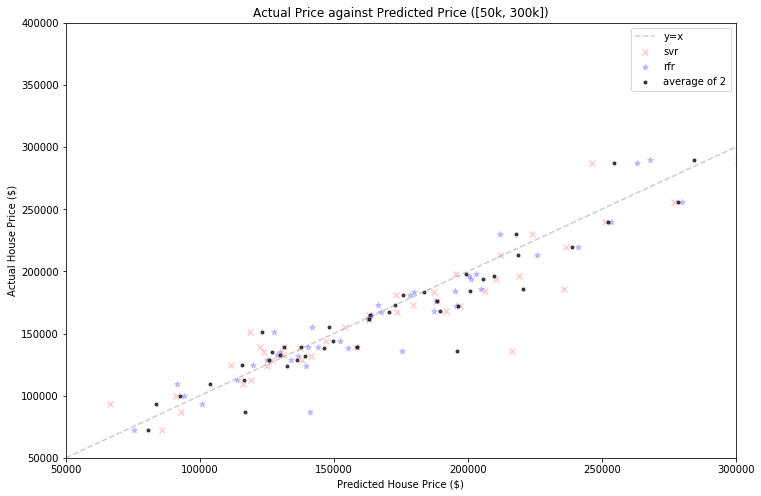

In [38]:
# Let's zoom in on the 50,000 to 300,000 range, the bulk of the prices

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

ax.set_title('Actual Price against Predicted Price ([50k, 300k])')
# svrs in red
ax.scatter(y_pred, y_test, color='red', marker='x', 
           alpha=0.2, label='svr')

# rfrs in blue
ax.scatter(rfr.predict(x_test.values), y_test, marker='*',
           color='blue', alpha=0.2, label='rfr')

# average in black
ax.scatter([(r+s)/2.0 for r, s in zip(rfr.predict(x_test.values), y_pred)],
           y_test, marker='.',
           color='black', alpha=0.7, label='average of 2')

min_point = min([ min(y_test), min(y_pred)])
max_point = max([ max(y_test), max(y_pred)])
ax.plot([50000, max_point], [50000, max_point],
        color='gray', linestyle='dashed', markersize=24,
        alpha=0.4, label='y=x')


ax.set_xlim(50000, 300000)
ax.set_ylim(50000, 400000)
ax.set_xlabel('Predicted House Price ($)')
ax.set_ylabel('Actual House Price ($)')
plt.legend()
plt.show()

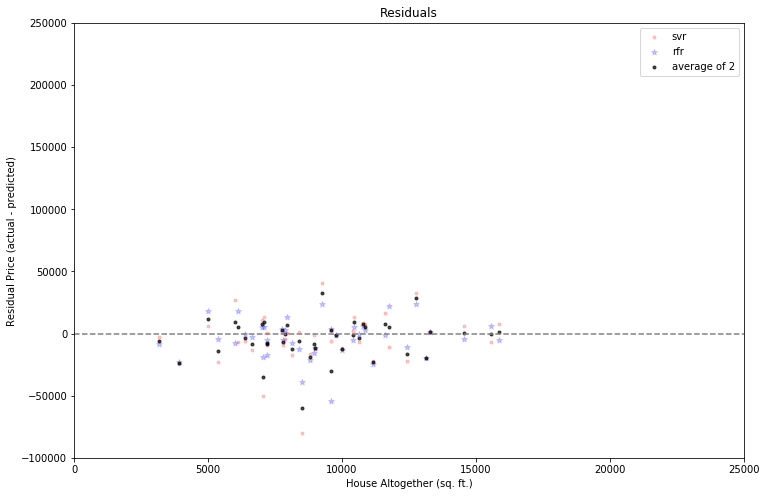

In [39]:
# Now plot the residuals against some arbitrary variable, say, house square feet

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)
# svrs in blue
ax.scatter(x_test.LotArea, y_test - y_pred, color='red', marker='.',
           alpha=0.2, label='svr')

# rfrs in green
ax.scatter(x_test.LotArea, y_test - rfr.predict(x_test.values), color='blue',
           marker='*', alpha=0.2, label='rfr')

# average
ax.scatter(x_test.LotArea,
           y_test - [(r+s)/2.0 for r, s in zip(rfr.predict(x_test.values), y_pred)],
           marker='.',
           color='black', alpha=0.7, label='average of 2')

ax.axhline(y=0, color='gray', linestyle='dashed')
ax.set_title('Residuals')
ax.set_xlabel('House Altogether (sq. ft.)')
ax.set_ylabel('Residual Price (actual - predicted)')
ax.set_xlim(0, 25000)
ax.set_ylim(-100000, 250000)
plt.legend()
plt.show()

In [40]:
print('Averaging SVR and RFR predictoins yields an RMSLE of {}'.format(rmsle(y_test, [(r+s)/2.0 for r,s in zip(rfr.predict(x_test.values), svr.predict(ss.transform(x_test.values)))])))

Averaging SVR and RFR predictoins yields an RMSLE of 0.10246102533037348


In [41]:
# Submit, for each prediction, the average prediction of the SVR and the RFR
df_test['SalePrice'] = [(r+s)/2.0 for r, s in zip(rfr.predict(df_test.drop('SalePrice', axis=1).values),
                                                 svr.predict(ss.transform(df_test.drop('SalePrice', axis=1).values)))]

df_test[['Id', 'SalePrice']].to_csv('svr_and_rfr_avgd_pred.csv', 
                                    index=False)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
# Output SVR on its own for Kaggle submission
df_test['SalePrice'] = rfr.predict(df_test.drop('SalePrice', axis=1).values)
df_test[['Id', 'SalePrice']].to_csv('rfr_solo_pt126_pred.csv', 
                                    index=False)

# Output SVR on its own for Kaggle submission
df_test['SalePrice'] = svr.predict(ss.transform(df_test.drop('SalePrice', axis=1).values))
df_test[['Id', 'SalePrice']].to_csv('svr_solo_pt109_pred.csv', 
                                    index=False)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Very much to my surprise, taking the average of the random forest regressor (rfr) and the support vector regressor (svr) produced a significantly better model according to the Kaggle public leaderboards. The individual rfr scored an RMSLE of 0.14574, and the individual svr scored an RMSLE of 0.15064. Averaging their predictions, however, yielded an RMSLE of **0.13059!** This is a fantastic improvement: going from the best performing random forest: 0.144 at 2272nd place (of 4969 teams); to this average 0.13059 at 1554th place (of 4974 teams). Given that this model far exceeded expectations and that this model is currently placing in the top 32% of models (ahead of 68% of the best, other submitted models), this is the stopping point for this notebook.